# Final Exam

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.optimize import minimize

***

# Instructions

## Please note the following:

Time
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Submission
* You will upload your solution to the Final Exam assignment on Canvas.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:

#### Section 2
* New file: `select_maturities_2017-02-07.xlsx`

#### Section 3
* Familiar file: `famabliss_strips_2023-12-29.xlsx`

In [28]:
path2 = '../data/select_maturities_2017-02-07.xlsx'
path3 = '../data/famabliss_strips_2023-12-29.xlsx'

df2 = pd.read_excel(path2).set_index('kytreasno')
df3 = pd.read_excel(path3).set_index('date')


## Scoring

| Problem | Points |
|---------|--------|
| 1       | 25     |
| 2       | 45     |
| 3       | 60     |
| 4       | 35     |
| **Total**   | **165**|

***

# 1. Long-Short Trades

Consider the following market data as of `Dec 29, 2023`.

The table below shows two Treasury securities, a T-note and a T-bond. They mature on the same date.

In [7]:
import pandas as pd
summary = pd.DataFrame(index=[],columns = [207391,204095],dtype=float)
summary.loc['issue date'] = ['2019-08-15','1999-08-15']
summary.loc['maturity date'] = ['2029-08-15','2029-08-15']
summary.loc['coupon rate'] = [.01625, .06125]
summary.loc['clean price'] = [89.03125,111.0391]
summary.loc['accrued interest'] = [.6005, 2.2636]
summary.loc['ytm'] = [.037677, .038784]
summary.loc['duration'] = [5.3494,4.7967]
summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967


### 1.1. (5pts)

Explain the long-short trade you would enter based on the market data above, without any further calculation. 

# 1.1 Solution

Assuming their ytm spread should close, you would buy 204095 and short 207391 while being duration hedged. Higher ytm means the bond is cheaper.

### 1.2. (5pts)

Size your trade.
* Suppose the long side is set to $100 million market value. 
* Size the short to be duration-neutral.

Report the market value in the short-side of the trade and the number of long and short contracts.

In [18]:
# long 207391 cause lower ytm
summary.loc['dirty price'] = summary.loc['clean price'] + summary.loc['accrued interest']

dur_list = summary.loc['duration']

mkt_val1 = 100_000_000
mkt_val2 = - dur_list[204095] * mkt_val1 / dur_list[207391]

num1 = mkt_val1 / summary.loc['dirty price'][204095]
num2 = mkt_val2 / summary.loc['dirty price'][207391]

summary.loc['mkt_val'] = [mkt_val2, mkt_val1]
summary.loc['num contracts'] = [num2, num1]

print(f'You are long {num1} contracts of 204095 for total value {mkt_val1}.')
print(f'You are short {num2} contracts of 207391 for total value {mkt_val2}.')

You are long 882591.5004673322 contracts of 204095 for total value 100000000.
You are short -1000404.4342495766 contracts of 207391 for total value -89668000.14954948.


### 1.3. (5pts)

What are the risks of this trade in the short-term and in the long-term?

# 1.3 Solution

In the short term, the spread not closing or widening could lead to issues with the account. Given leverage, we may need to commit more funds to our trade.

In the long term, changes in the yield curve could lead to changes in duration, leading to different duration hedging and exposure to yield changes.

### 1.4. (5pts)

Use **modified duration**--not the Macauley duration reported above--to estimate how much pnl will be earned if the securities converge (symmetrically).

In [20]:
summary.loc['modified duration'] = summary.loc['duration'] / (1 + summary.loc['ytm'] / 2)

mean_ytm = summary.loc['ytm'].mean()

summary.loc['PnL converge'] = - (mean_ytm - summary.loc['ytm']) * summary.loc['mkt_val'] * summary.loc['modified duration']

summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967
dirty price,89.63175,113.3027
num contracts,-1000404.43425,882591.500467
mkt_val,-89668000.149549,100000000


In [22]:
print(f'We make {summary.loc['PnL converge'].sum()} in PnL if the yields converge symmetrically.')

We make 521035.01459511206 in PnL if the yields converge symmetrically.


### 1.5. (5pts)

For which of these securities will the duration approximation be less accurate? Explain.

# 1.5 Solution

Higher coupons mena lower convexity in cash flows. Thus, the duration approximation is more accurate with 204095 and less accurate with 207391.

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `select_maturities_2017-02-07.xlsx`.

* Market quots are provided for treasury securities expiring approximately every six months over the next ten years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price. Use it as quoted, without further adjustment.

### 2.1 (10pts)

Bootstrap the spot curve. Report it in both...
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [67]:
from pandas.tseries.offsets import DateOffset

def cashflow_matrix_mod(data, face_val=100, coupon_freq='6ME', maturity=False):
    data['maturity date'] = pd.to_datetime(data['maturity date'])
    data['date'] = pd.to_datetime(data['date'])

    all_dates = pd.date_range(
        start=data['date'].min() + DateOffset(days=1),
        end=data['maturity date'].max(),
        freq='D'
    )

    cash_flow_matrix = pd.DataFrame(0, index=data.index, columns=all_dates)

    maturity_dates = set(data['maturity date'])  # Store maturity dates
    q_date = data.iloc[0]['date']

    for idx, row in data.iterrows():
        payment_dates = []
        current_date = row['maturity date']
        
        # Count backwards in 6-month intervals
        while current_date >= row['date']:
            # Adjust February 28/29 to August 31
            if current_date.month == 2 and current_date.day in [28, 29]:
                current_date = current_date + DateOffset(months=6)  # Move to August
                current_date = current_date.replace(day=31)  # Ensure it lands on August 31

            payment_dates.append(current_date)
            current_date -= DateOffset(months=6)  # Move backward in 6-month intervals

        # Ensure the dates are sorted in ascending order
        payment_dates = sorted(payment_dates)

        # Calculate coupon payment amount
        cpn_payment = row['cpn rate'] / 100 * face_val / 2

        # Assign coupon payments to the cash flow matrix
        cash_flow_matrix.loc[idx, payment_dates] = cpn_payment
        cash_flow_matrix.loc[idx, row['maturity date']] += face_val  # Add face value only at maturity

    cash_flow_matrix = cash_flow_matrix.fillna(0)

    # Remove initial date column if present
    if q_date in set(cash_flow_matrix.columns):
        cash_flow_matrix = cash_flow_matrix.drop(columns={q_date})

    # Remove all-zero columns to keep only relevant dates
    cash_flow_matrix = cash_flow_matrix.loc[:, (cash_flow_matrix != 0).any(axis=0)]
    cash_flow_matrix = cash_flow_matrix.sort_index(axis=1)
    
    if maturity:
        non_maturity_cols = list(set(cash_flow_matrix.columns) - set(maturity_dates))
        print(non_maturity_cols)

        if non_maturity_cols:
            bonds_with_invalid_cashflows = (cash_flow_matrix[non_maturity_cols] != 0).any(axis=1)
            cash_flow_matrix = cash_flow_matrix.loc[~bonds_with_invalid_cashflows]
        
        new_mat_set = set(data[data.index.isin(set(cash_flow_matrix.index))]['maturity date'])
        cash_flow_matrix = cash_flow_matrix[list(new_mat_set)].sort_index(axis=1)

    return cash_flow_matrix


In [68]:
cf_df = cashflow_matrix_mod(df2, maturity=True)

KeyboardInterrupt: 

In [61]:
cf_df

""
kytreasno


In [54]:
def estimate_discount_factors(price_df, cf_df):
    """
    Estimates discount factors using OLS regression based on the equation:
        p = C z + e
    where:
        - p: Vector of bond prices from price_df.
        - C: Cash flow matrix from cf_df.
        - z: Estimated discount factors.
        - e: Error term.

    Parameters:
    price_df (pd.DataFrame): DataFrame with treasury number as index and a column 'price'.
    cf_df (pd.DataFrame): DataFrame with treasury number as index and columns as cash flow dates.

    Returns:
    pd.Series: Estimated discount factors indexed by cash flow dates.
    """
    # Ensure indices match between price_df and cf_df
    common_index = price_df.index.intersection(cf_df.index)
    p = price_df.loc[common_index, 'price'].values  # Extract prices
    C = cf_df.loc[common_index].values  # Extract cash flow matrix

    # Perform OLS regression
    model = sm.OLS(p, C)  # No intercept since cash flows sum to price
    results = model.fit()

    # Extract estimated discount factors
    z = pd.DataFrame(results.params, index=cf_df.columns, columns=['Discount Factors'])
    z.index.name = 'date'
    
    return z, results

In [55]:
df2['price'] = df2['bid'] + df2['ask']

price_df = df2[['price']]

z, res = estimate_discount_factors(price_df, cf_df)

In [56]:
z

,Discount Factors
date,
2017-02-15,0.178640
2017-02-28,0.157363
2017-08-15,0.178640
2017-08-28,0.151156
2017-08-31,1.992578
2018-02-15,0.178640
2018-02-28,1.988496
2018-08-15,0.178640
2018-08-28,0.136887


### 2.2 (10pts)

Calculate the Nelson-Siegel curve using the parameters below. (Not the NS-extended; just four parameters.)

Report both
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [70]:
def nelson_siegel(ttm, beta0, beta1, beta2, lmda):
    """Nelson-Seigel yield curve model."""
    term = ttm / lmda
    return beta0 + beta1 * ((1 - np.exp(-term)) / term) + beta2 * (((1 - np.exp(-term)) / term) - np.exp(-term))

def price_error(params, price_ttm_df, cf_df):
    """Objective function: Sum of squared pricing errors."""
    beta0, beta1, beta2, lmda = params
    
    # Compute discount factors using Nelson-Siegel model
    yields = nelson_siegel(price_ttm_df['ttm'].values, beta0, beta1, beta2, lmda)
    discount_factors = np.exp(-yields * price_ttm_df['ttm'].values)
    
    # Ensure discount_factors is properly shaped for element-wise multiplication
    estimated_prices = (cf_df.values * discount_factors[:, None]).sum(axis=1)
    
    # Compute sum of squared errors
    return np.sum((price_ttm_df['price'].values - estimated_prices) ** 2)


def estimate_discount_factors(price_ttm_df, cf_df):
    """Estimate discount factors using Nelson-Seigel model."""
    initial_guess = [0.02, -0.02, 0.02, 1.0]  # Initial values for beta0, beta1, beta2, lmda
    bounds = [(None, None), (None, None), (None, None), (0.001, None)]  # Lambda must be positive
    
    result = minimize(price_error, initial_guess, args=(price_ttm_df, cf_df), bounds=bounds)
    
    if result.success:
        beta0, beta1, beta2, lmda = result.x
        estimated_yields = nelson_siegel(price_ttm_df['ttm'], beta0, beta1, beta2, lmda)
        discount_factors = np.exp(-estimated_yields * price_ttm_df['ttm'])
        
        factors = {'beta0': beta0, 'beta1': beta1, 'beta2': beta2, 'lmda': lmda}

        resdf = pd.DataFrame({
            'Discount Factors': discount_factors,
            'date': price_ttm_df['date'].values  # Ensure values match correctly
        }, index=price_ttm_df.index)



        return factors, resdf
    else:
        raise ValueError("Optimization failed: " + result.message)


In [2]:
params = pd.DataFrame(columns=['Nelson-Siegel parameters'],index=['theta0', 'theta1','theta2','lambda1'],data=[0.031627,-0.025166, -0.020701, 1.514887]).T
display(params)

,theta0,theta1,theta2,lambda1
Nelson-Siegel parameters,0.031627,-0.025166,-0.020701,1.514887


In [71]:
ttm_df = df2[['date', 'ttm']] 

ttm_df['discount factor'] = nelson_siegel(ttm_df['ttm'], 0.031627,-0.025166, -0.020701, 1.514887)

C:\Users\vince\AppData\Local\Temp\ipykernel_22960\180395532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttm_df['discount factor'] = nelson_siegel(ttm_df['ttm'], 0.031627,-0.025166, -0.020701, 1.514887)


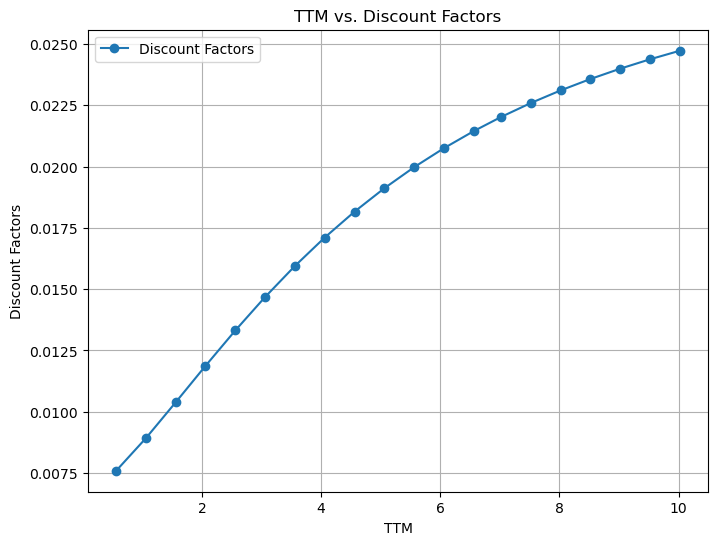

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(ttm_df['ttm'], ttm_df['discount factor'], marker='o', linestyle='-', label='Discount Factors')
plt.title('TTM vs. Discount Factors')
plt.xlabel('TTM')
plt.ylabel('Discount Factors')
plt.grid(True)
plt.legend()
plt.show()

### 2.3 (5pts)

Plot...
* bootstrapped spot rates
* Nelson-Siegel spot rates
* provided ytm

### 2.4 (10pts)

Which of the two spot rate curves (bootstrapped or Nelson-Siegel) would be better for...
* pricing the provided sample
* building spot rates out to 30 years
* calculating forward rates

For each of these three questions, be **specific** in your answer.

# 2.4 Solution

For pricing the sample, the bootstrap is perfect.

For building out spot rates, Nelson Siegel is more applicable.

For calculating forward rates, Nelson Siegel is also better for interpolating.

### 2.5 (5pts)

Consider the bootstrapped curve and its associated forward curve. (No need to calculate the forward curve.)

Conceptually, do you expect it is higher or lower than the spot-rate curve at
* $T=1$
* $T=10$

Explain.

### 2.6 (5pts)

Use the bootstrapped spot curve to calculate the forward rate for $T_1=3\to T_2=3.5$.

***

# 3. Trading the Yield Curve



Use the file, `famabliss_strips_2023-12-29.xlsx` for the following problem.

* The file provides prices for **strips** which are zero-coupon bonds. 
* Assume face value of 100.
* Because these prices are on zero-coupon bonds, they can be interpreted as discount factors, $Z$, directly.

Note that you will make use of only a few rows of the data set.

In [73]:
df3.head()

,1,2,3,4,5
date,,,,,
1952-06-30,98.177763,96.253133,94.246713,92.634134,90.418295
1952-07-31,98.094756,96.031453,93.931226,92.308865,89.851576
1952-08-29,98.057808,95.974988,93.781939,92.145776,89.571687
1952-09-30,98.031188,95.909789,93.755108,92.096104,89.167641
1952-10-31,98.110769,95.974490,93.758273,91.929019,89.724841


### 1. (10pts)

Set up a trade as of `2010-01-29` to 
* go long 100 million (market value) of the 5-year.
* short the 2-year strips in a quantity that is duration hedged.

List the positions you hold long and short. 
* Assume you are financing the positions directly; no worries about haircuts. 
* Assume there are no market frictions, so you can short securities and immediately receive their market value. 
* (No need to worry about borrowing costs for the short.)

In [75]:
# 0 coupon means duration is index
mk5 = 100_000_000
mk2 = - mk5 * 5 / 2
num5 = mk5 / df3.loc['2010-01-29'][5]
num2 = mk2 / df3.loc['2010-01-29'][2]

print(f'We are long {num5} contracts of the 5 year strip with {mk5} value.')
print(f'We are short {num2} contracts of the 5 year strip with {mk2} value.')



We are long 1124880.4923065926 contracts of the 5 year strip with 100000000 value.
We are short -2539847.7258298844 contracts of the 5 year strip with -250000000.0 value.


### 2. (5pts)
As of `2011-01-31`, assess the pnl on the long, short, and net trade.

In [77]:
w5 = num5 * df3.loc['2011-01-31'][4]
w2 = num2 * df3.loc['2011-01-31'][1]

print(f'Long PnL on the former 5 year strips is {w5 - mk5}.')
print(f'Short PnL on the former 2 year strips is {w2 - mk2}.')
print(f'Total PnL is {w5 + w2 - mk5 - mk2}.')


Long PnL on the former 5 year strips is 6179199.310385317.
Short PnL on the former 2 year strips is -3195323.560800165.
Total PnL is 2983875.7495851517.


### 3. (10pts)
On `2011-01-31`, roll over the trade.
* close out the short positions
* enter new short positions in 2-year strips that are a duration hedge against your (continuing) long positions.

List the details of your short and long positions in terms of market value and face value of each side of the trade.

### 4. (5pts)
On `2012-01-31`, close out the trade.

Report...
* pnl for the long, short, and net of the trade.

### 5. (5pts)
How did this trade do compared to a long-only trade in 5-year notes? Explain.

### 6. (5pts)

Notwithstanding the duration hedge, why was the trade still sensitive to changing levels of the spot rate curve?

Be specific in your answer, and consider which quantitative metric would support your answer.

### 7. (5pts)

Does this trade rely on the Expectations Hypothesis being true or false? How about this type of trade in general?

### 8. (5pts)

As of `2012-01-31`, is the market environment favorable to this type of long-short trade?

Be specific.

### 9. (5pts)

As of `2010-01-29`, what is the continuously compounded forward rate from $T_1=2\to T_2=4$?

### 10. (5pts)

As of `2012-01-31`, is the two-year continuously-compoounded spot rate, $r(0,2)$ higher or lower than the forward rate calculated above for `2010-01-29`?

Is this surprising?

***

# 4. The Swap-Spread

Consider the market data below. 
* It refers to **20-year** T-bonds and swaps.
* Assume the T-bond has exactly 20-years to maturity, with a coupon that exactly matches the YTM below.

In [78]:
summary = pd.DataFrame(index=['YTM','swap rate'],columns = ['Nov 2018','Nov 2023'],dtype=float)
summary.loc['YTM'] = [.031480, .046670]
summary.loc['swap rate'] = [.027639,.039895]
summary.style.format('{:.4%}')

,Nov 2018,Nov 2023
YTM,3.1480%,4.6670%
swap rate,2.7639%,3.9895%


### 4.1. (5pts)

Consider `Nov 2018`. Suppose you enter into a swap-spread trade.
* You go long \$100 million **market value** of 20-year T-bonds.
* You simultaneously enter a 20-year swap, paying-fixed, with notional of \$100 million.


Report the 
* price of the T-bond in Nov 2018.
* amount of T-bonds purchased, (each face value of 100).

In [79]:
def bond_price(cpn, ytm, years, years_past, compounding=2, FV=100):
    price = 0

    for i in np.arange(years_past + 1 / compounding, years + 1 / compounding, 1 / compounding):
        z = 1 / (1 + ytm/compounding) ** (compounding * (i - years_past))
        val = cpn * FV * z / compounding
        price += val

    price += (FV) / ((1 + ytm/compounding) ** (compounding * (years - years_past)))

    return float(price)

In [80]:
# if cpn is ytm, then mkt is face

print('Price of a t-bond is 100.')
print('Purchased 1000000 t bonds.')

Price of a t-bond is 100.
Purchased 1000000 t bonds.


### 4.2. (5pts)

Report the first cashflow of the trade, in May 2019.

For simplicity, 
* assume the swap pays semiannually, at the same date the T-bond pays coupons.
* the repo rate involved in the trade cancels out with the floating rate of the swap.
* the repo term is semiannually, corresponding to the coupon and swap dates.
* there are not any margin calls or distributions in the discussion below.

If the haircut is 4\% to repo the T-bonds, then what is the May 2019 cashflow as a percentage of the equity capital in the position?

### 4.3. (5pts)

Report the risk of the trade.
* Duration and dollar duration for the T-bond
* Duration and dollar duration for the swap

Note that you are reporting the usual, Macauley, duration--not the modified duration. 

For each of these duration calculations, use only the YTM and swap rates--no need for a discount curve.

### 4.4. (5pts)

Use **modified** duration to answer the following:

* What is the expected profit and loss if the swap-spread goes to zero?
* What return would this be relative to the initial equity capital to put on the position?

#### Note:
We refer to the spread (swap-rate minus T-bond YTM) going to zero symmetrically (the YTM falls and swap rate rise equally until converging.)

### 4.5. (10pts)

Now it is `Nov 2023`. Use the market quotes to report...
* the value of the long T-bond positions (15 years-to-maturity)
* the value of the paying-fixed swap (15 years-to-expiration)
* the net value of your position and return on your equity capital.

### 4.6. (5pts)

Assume there are no market frictions, and there is more credit risk in the swap than in the T-bond.

In that case, is the swap-spread trade an arbitrage, a statistically favorable trade, both, or neither? 

Be specific whether your answer is for the long-term or short-term.

***